# Data Cleaning: Angle-Based Outlier Detection
- In this notebook, we will use a subset of Real State Price dataset from Kaggle in file "kaggle_house_outlier.csv". For simplicity, we will focus only on numerical attributes.
- We will implement the angle-based high-dimensional data cleaning method in this dataset, where a point is defined as an outlier if the standard deviation of the all angle pairs is less thana certain angle (e.g., 20 degrees).
- Recall that an angle is always between 0 and 360.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
%matplotlib inline

In [2]:
data_directory = r"C:\Users\sb013698\Desktop\github\Machine Learning in Finance\Datasets"

**Angle-Based Outlier Detection (ABOD)** identifies outliers by analyzing the variance of angles formed between data points in high-dimensional space. Points with low angular variance exhibit weaker interactions and are classified as outliers, while points with high angular variance are surrounded by many other points in all directions, indicating they are not outliers.


<img src="Datasets/angle_based_outlier_detection.png" alt="Description of the figure" width="750">

Figure URL: https://machinelearningstories.blogspot.com/2018/08/anomaly-detection-in-high-dimensional.html

In [3]:
# Load the dataset
data = pd.read_csv(os.path.join(data_directory, "kaggle_house_outlier.csv"))
print(data.shape)

(151, 81)


In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60.0,RL,65.0,8450.0,Pave,NaN,Reg,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0.0,2.0,2008.0,WD,Normal,208500.0
1,2.0,20.0,RL,80.0,9600.0,Pave,NaN,Reg,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0.0,5.0,2007.0,WD,Normal,181500.0
2,3.0,60.0,RL,68.0,11250.0,Pave,NaN,IR1,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0.0,9.0,2008.0,WD,Normal,223500.0
3,4.0,70.0,RL,60.0,9550.0,Pave,NaN,IR1,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,5.0,60.0,RL,84.0,14260.0,Pave,NaN,IR1,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0.0,12.0,2008.0,WD,Normal,250000.0


In [5]:
# Step 2: Filter numerical columns only
numerical_data = data.select_dtypes(include=[np.number])
numerical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    float64
 1   MSSubClass     150 non-null    float64
 2   LotFrontage    124 non-null    float64
 3   LotArea        150 non-null    float64
 4   OverallQual    150 non-null    float64
 5   OverallCond    150 non-null    float64
 6   YearBuilt      150 non-null    float64
 7   YearRemodAdd   150 non-null    float64
 8   MasVnrArea     150 non-null    float64
 9   BsmtFinSF1     150 non-null    float64
 10  BsmtFinSF2     150 non-null    float64
 11  BsmtUnfSF      150 non-null    float64
 12  TotalBsmtSF    150 non-null    float64
 13  1stFlrSF       150 non-null    float64
 14  2ndFlrSF       150 non-null    float64
 15  LowQualFinSF   150 non-null    float64
 16  GrLivArea      150 non-null    float64
 17  BsmtFullBath   150 non-null    float64
 18  BsmtHalfBa

In [6]:
# Remove unnecessary columns
cols_to_remove = ["Id", "PoolArea", "PoolQC"]
numerical_data = numerical_data.drop(columns=cols_to_remove)

# Apply mean imputation for the columns with relatively less missing values
numerical_data = numerical_data.apply(lambda x: x.fillna(x.mean()))

numerical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     151 non-null    float64
 1   LotFrontage    151 non-null    float64
 2   LotArea        151 non-null    float64
 3   OverallQual    151 non-null    float64
 4   OverallCond    151 non-null    float64
 5   YearBuilt      151 non-null    float64
 6   YearRemodAdd   151 non-null    float64
 7   MasVnrArea     151 non-null    float64
 8   BsmtFinSF1     151 non-null    float64
 9   BsmtFinSF2     151 non-null    float64
 10  BsmtUnfSF      151 non-null    float64
 11  TotalBsmtSF    151 non-null    float64
 12  1stFlrSF       151 non-null    float64
 13  2ndFlrSF       151 non-null    float64
 14  LowQualFinSF   151 non-null    float64
 15  GrLivArea      151 non-null    float64
 16  BsmtFullBath   151 non-null    float64
 17  BsmtHalfBath   151 non-null    float64
 18  FullBath  

In [7]:
numerical_data.shape

(151, 36)

In [8]:
# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data.values)

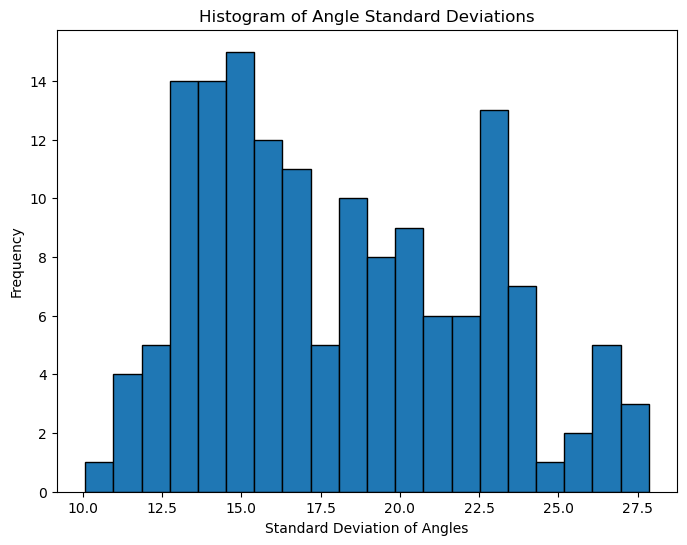

In [9]:
# First, observe the distribution of the standard deviation of angles
np.random.seed(42)

# Calculate cosine similarities
cos_sim_matrix = cosine_similarity(scaled_data)

# Convert cosine similarities to angles in radians, and then degrees
angle_matrix = np.arccos(np.clip(cos_sim_matrix, -1, 1)) * (180 / np.pi)

# Store the the standard deviation of angles for each point
std_list = list()

# Calculate the standard deviation of angles for each point
for i in range(angle_matrix.shape[0]):
    angle_std_dev = np.std(angle_matrix[i, :])
    std_list.append(angle_std_dev)

# Plot histogram of the standard deviation values
plt.figure(figsize=(8, 6))
plt.hist(std_list, bins=20, edgecolor='black')
plt.title('Histogram of Angle Standard Deviations')
plt.xlabel('Standard Deviation of Angles')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [10]:
# We see that std. of the angles are distributed btw. 10-28 degrees.
# Thus, we should select a reasonable angle threshold to define outlier.

# Define an angle threshold
threshold = 12.5

# Store outlier indices
outliers = list()

# Calculate the standard deviation of angles for each point
for i in range(angle_matrix.shape[0]):
    angle_std_dev = np.std(angle_matrix[i, :])
    
    # Identify outliers based on angle standard deviation threshold
    if angle_std_dev < threshold:
        outliers.append(i)

# Step 6: Output the results
print(f"Number of detected outliers: {len(outliers)}")
print("Outlier indices:", outliers)

Number of detected outliers: 9
Outlier indices: [3, 5, 33, 50, 51, 55, 88, 129, 142]


# Predicting House Price with Linear Regression

- We will now focus on the Real Estate Price dataset from Kaggle to implement a linear regression model using sklearn. The goal is to predict house prices (last column) based on the following attributes: MSSubClass, LotFrontage, LotArea, MasVnrArea, BsmtFinSF1, and YrSold.
- Additionally, we will apply a t-test from the statsmodels library to assess the significance of each attribute in predicting the house price.

In [11]:
# Open training and test datasets
house_train = pd.read_csv(os.path.join(data_directory, "kaggle_house_pred_train.csv"))
house_test = pd.read_csv(os.path.join(data_directory, "kaggle_house_pred_test.csv"))

# Define the required attributes
required_columns = ["MSSubClass", "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "YrSold", "SalePrice"]

# Map the required columns from the training and test datasets
train_data = house_train[required_columns].copy()
test_data = house_test[required_columns].copy()

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1460 non-null   int64  
 1   LotFrontage  1201 non-null   float64
 2   LotArea      1460 non-null   int64  
 3   MasVnrArea   1452 non-null   float64
 4   BsmtFinSF1   1460 non-null   int64  
 5   YrSold       1460 non-null   int64  
 6   SalePrice    1460 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 80.0 KB


In [13]:
# Apply mean imputation for missing values in the training data
train_data["LotFrontage"] = train_data["LotFrontage"].fillna(train_data["LotFrontage"].mean())
train_data["MasVnrArea"] = train_data["MasVnrArea"].fillna(train_data["MasVnrArea"].mean())

# Display updated information about the test data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1460 non-null   int64  
 1   LotFrontage  1460 non-null   float64
 2   LotArea      1460 non-null   int64  
 3   MasVnrArea   1460 non-null   float64
 4   BsmtFinSF1   1460 non-null   int64  
 5   YrSold       1460 non-null   int64  
 6   SalePrice    1460 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 80.0 KB


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1459 non-null   int64  
 1   LotFrontage  1232 non-null   float64
 2   LotArea      1459 non-null   int64  
 3   MasVnrArea   1444 non-null   float64
 4   BsmtFinSF1   1458 non-null   float64
 5   YrSold       1459 non-null   int64  
 6   SalePrice    1459 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 79.9 KB


In [15]:
# Apply mean imputation for missing values in the test data
test_data["LotFrontage"] = test_data["LotFrontage"].fillna(test_data["LotFrontage"].mean())
test_data["MasVnrArea"] = test_data["MasVnrArea"].fillna(test_data["MasVnrArea"].mean())
test_data["BsmtFinSF1"] = test_data["BsmtFinSF1"].fillna(test_data["BsmtFinSF1"].mean())

# Display updated information about the test data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1459 non-null   int64  
 1   LotFrontage  1459 non-null   float64
 2   LotArea      1459 non-null   int64  
 3   MasVnrArea   1459 non-null   float64
 4   BsmtFinSF1   1459 non-null   float64
 5   YrSold       1459 non-null   int64  
 6   SalePrice    1459 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 79.9 KB


In [16]:
# Define features and targets
X_train, y_train = train_data.drop(columns="SalePrice"), train_data["SalePrice"].values
X_test, y_test = test_data.drop(columns="SalePrice"), test_data["SalePrice"].values

# Normalize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Create a linear regression model
model = LinearRegression()

# Train the model and make predictions
model.fit(X_train_scaled, y_train)
preds = model.predict(X_test_scaled)

# Evaluate the model's performance on the test set
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
mape = mean_absolute_percentage_error(y_test, preds)

print(f"R2: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"MAPE: {mape:.3f}")

R2: -6.041
MSE: 1919871062.367
MAPE: 0.178


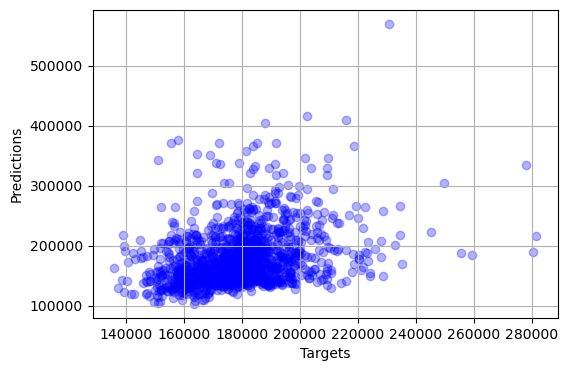

In [18]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(6, 4))
plt.scatter(y_test, preds, alpha=0.3, color='b')
plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## T-Test

In [19]:
# Add a constant for intercept
X_train_with_const = sm.add_constant(X_train_scaled)

# Train the model
model = sm.OLS(y_train, X_train_with_const).fit()

# Print regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     134.3
Date:                Thu, 09 Jan 2025   Prob (F-statistic):          2.22e-135
Time:                        20:00:47   Log-Likelihood:                -18222.
No. Observations:                1460   AIC:                         3.646e+04
Df Residuals:                    1453   BIC:                         3.649e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.809e+05   1671.018    108.270      0.0

**Discussion:** The following coefficients, x2, x3, x4, and x5, have large t-values and small p-values. This indicates strong evidence against the null hypothesis that these coefficients are zero. Thus, these features are statistically significant in the regression.

Significant features in predicting house price:
- x2: LotFrontage
- x3: LotArea
- x4: MasVnrArea
- x5: BsmtFinSF1

# END